In [193]:
# assignment 1

#load data
import torch
import torchvision
import os
import matplotlib
import random
#将数据划分成训练集和测试集,存储成train.txt,test.txt(data.txt包括5个字段，图片路径 人 朝向 情绪 眼镜)
#每张图片有0.2的几率进入测试集

root = os.getcwd()
file_path = root + '/emotion/faces_4/'

name_dict = {'an2i':0,'at33':1,'boland':2,'bpm':3,'ch4f':4,'cheyer':5,'choon':6,'danieln':7,\
            'glickman':8,'karyadi':9,'kawamura':10,'kk49':11,'megak':12,'mitchell':13,'night':14,'phoebe':15,\
             'saavik':16,'steffi':17,'sz24':18,'tammo':19
            }
name_list = ['an2i','at33','boland','bpm','ch4f','cheyer','choon','danieln',\
            'glickman','karyadi','kawamura','kk49','megak','mitchell','night','phoebe',\
             'saavik','steffi','sz24','tammo']

with open("train.txt",'w') as train_fw:
    with open("test.txt",'w') as test_fw:
        for root,dirs,files in os.walk(file_path):
            for tmp in dirs:
                tmp_path = file_path + tmp
                for x,y,images in os.walk(tmp_path):
                    for image in images:     
                        image_name = image.split("_")
                        name = image_name[0]
                        direction = image_name[1]
                        emotion = image_name[2]
                        glass = image_name[3]
                        random_num = random.uniform(0.,1.)
                        if random_num <0.2:
                            test_fw.write(tmp_path+"/"+image+" "+str(name_dict[name])+" "+direction+" "+emotion+" "+glass+"\n")
                        else:
                            train_fw.write(tmp_path+"/"+image+" "+str(name_dict[name])+" "+direction+" "+emotion+" "+glass+"\n")
                
                
# training_set = (
#     torchvision.datasets.mnist.read_image_file(os.path.join('/home/kuangjun/course/机器学习/emotion', 'train-images-idx3-ubyte/data')),
#     torchvision.datasets.mnist.read_label_file(os.path.join('/home/kuangjun/course/机器学习/mnist', 'train-labels-idx1-ubyte/data'))
# )
# testing_set = (
#     torchvision.datasets.mnist.read_image_file(os.path.join('/home/kuangjun/course/机器学习/mnist','t10k-images-idx3-ubyte/data')),
#     torchvision.datasets.mnist.read_label_file(os.path.join('/home/kuangjun/course/机器学习/mnist','t10k-labels-idx1-ubyte/data'))
# )

In [189]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image

#hyper parameters
EPOCH = 20
BATCH_SIZE = 32
LR = 0.0005  #学习率 
def default_loader(path):
    return Image.open(path).convert('L')
class MyDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0],int(words[1])))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.imgs)

root = os.getcwd()
train_data=MyDataset(txt=root+'/train.txt', transform=transforms.ToTensor())
test_data=MyDataset(txt=root+'/test.txt', transform=transforms.ToTensor())
#一个batch BATCH_SIZE个sample , 1 channel, 28*28 (BATCH_SIZE,1,28,28)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)



In [191]:
import torch.nn.functional as F
#构建网络，进行训练

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(  # input shape (1, 32, 32)
            torch.nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=7,      # filter size
                stride=1,           # filter movement/step
                padding=3,      
            ),      # output shape (16, 32, 32)
            torch.nn.ReLU(),    # activation
            torch.nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 16, 16)
        )
        self.conv2 = torch.nn.Sequential(  # input shape (16, 16, 16)
            torch.nn.Conv2d(16, 32, 7, 1, 3),  # output shape (32, 16, 16)
            torch.nn.ReLU(),  # activation
            torch.nn.MaxPool2d(2),  # output shape (32, 8, 8)
        )
        self.out = torch.nn.Linear(32 * 8 * 8, 20)   # fully connected layer, output 10 classes

    def forward(self, x):
        #将1*32*32补成1*32*32
        x = F.pad(x,(0,0,1,1))
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 8 * 8)
        output = self.out(x)
        return output

    
model = Net()
print(model)

optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    print('epoch {}'.format(epoch + 1))
    # training-----------------------------
    train_loss = 0.
    train_acc = 0.
    for batch_x,batch_y in train_loader:
    
        batch_y = torch.tensor(list(batch_y))
       
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.data[0]
        pred = torch.max(out, 1)[1]
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_acc = train_acc.float()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
        train_data)), train_acc / (len(train_data))))
    

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for batch_x ,batch_y in test_loader:
        batch_x, batch_y = Variable(batch_x, volatile=True), Variable(batch_y, volatile=True)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        eval_loss += loss.data[0]
        pred = torch.max(out, 1)[1]
        num_correct = (pred == batch_y).sum()
        eval_acc += num_correct.data[0]
    eval_acc = eval_acc.float()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        test_data)), eval_acc / (len(test_data))))

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=20, bias=True)
)
epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Loss: 0.093893, Acc: 0.081673
Test Loss: 0.090894, Acc: 0.180328
epoch 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Loss: 0.075219, Acc: 0.346614
Test Loss: 0.060289, Acc: 0.467213
epoch 3
Train Loss: 0.044558, Acc: 0.525896
Test Loss: 0.033600, Acc: 0.655738
epoch 4
Train Loss: 0.023492, Acc: 0.766932
Test Loss: 0.019508, Acc: 0.803279
epoch 5
Train Loss: 0.012320, Acc: 0.888446
Test Loss: 0.012707, Acc: 0.827869
epoch 6
Train Loss: 0.006435, Acc: 0.944223
Test Loss: 0.004688, Acc: 0.983607
epoch 7
Train Loss: 0.003064, Acc: 0.990040
Test Loss: 0.003253, Acc: 0.967213
epoch 8
Train Loss: 0.003207, Acc: 0.968127
Test Loss: 0.002363, Acc: 1.000000
epoch 9
Train Loss: 0.001861, Acc: 0.990040
Test Loss: 0.001944, Acc: 0.991803
epoch 10
Train Loss: 0.002443, Acc: 0.982072
Test Loss: 0.004933, Acc: 0.942623
epoch 11
Train Loss: 0.001018, Acc: 0.994024
Test Loss: 0.000711, Acc: 0.991803
epoch 12
Train Loss: 0.000897, Acc: 0.994024
Test Loss: 0.000612, Acc: 0.991803
epoch 13
Train Loss: 0.000575, Acc: 0.996016
Test Loss: 0.000373, Acc: 1.000000
epoch 14
Train Loss: 0.000389, Acc: 0.998008
Test Loss: 

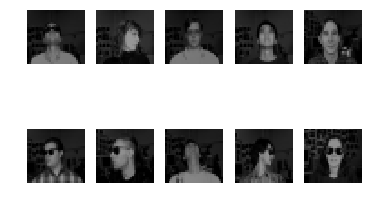

I guess these people above are:

at33,steffi,bpm,choon,sz24
night,kk49,karyadi,kawamura,saavik

The real answer is :
at33,steffi,bpm,choon,sz24
night,kk49,karyadi,kawamura,saavik


In [192]:
#加载测试集的前10张图片查看运行效果
%matplotlib inline
def default_loader(path):
    return Image.open(path).convert('L')
class MyVisualDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            imgs.append(line)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
            
        return img

    def __len__(self):
        return len(self.imgs)

from matplotlib import pyplot # pyplot 用于显示图片
from matplotlib import image # image 用于读取图片
from PIL import Image

root = os.getcwd()
real_answer = []
with open('visual_test.txt','w') as fw:
    with open("test.txt",'r') as fr:
        i = 0
        j = 5
        for line in fr:
            if(j%7):
                j+=1
                continue
            j+=1
            path = line.split()[0]
            name = line.split()[1]
            pic = Image.open(path)
            real_answer.append(name_list[int(name)])
            pyplot.subplot(2,5,i+1)
            pyplot.axis('off')
            pyplot.imshow(pic)
            i+=1 
            fw.write(path+'\n')
            if(i == 10):
                break
            
pyplot.show()
visual_data=MyVisualDataset(txt='visual_test.txt', transform=transforms.ToTensor())
visual_loader = DataLoader(dataset=visual_data, batch_size=1)

print("I guess these people above are:")
print("")
for index,x in enumerate(visual_loader):
    x = Variable(x)
    out = model(x)
    pred = torch.max(out, 1)[1]
    if((index+1)%5 !=0):
        print(name_list[pred.data.numpy()[0]],end=',')
    else:
        print(name_list[pred.data.numpy()[0]])

print()
print("The real answer is :")
i = 0
for name in real_answer:
    if((i+1)%5 !=0):
        print(name,end=',')
    else:
        print(name)
    i+=1